# Rehab Strength Dashboard – EDA Baseline

## Purpose
This notebook establishes the exploratory data analysis (EDA) foundation
for understanding training load, sleep behavior, and recovery signals
during rehabilitation.

The goal is not prediction, but clarity:
- What is normal?
- What is noise?
- What could indicate risk?


## Data Dictionary Reference

The full data dictionary for this project is maintained in:

`data_schema/data_dictionary.md`

This notebook assumes the definitions, granularity,
and limitations described there.


In [132]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates


## WORKOUTS

In [133]:
workouts = pd.read_csv("/Users/polux9589/Desktop/gym-ml-performance/data/raw/strong.csv")   #Upload workouts data
workouts.info()

<class 'pandas.DataFrame'>
RangeIndex: 6327 entries, 0 to 6326
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           6327 non-null   str    
 1   Workout Name   6327 non-null   str    
 2   Duration       6327 non-null   str    
 3   Exercise Name  6327 non-null   str    
 4   Set Order      6327 non-null   str    
 5   Weight         6327 non-null   float64
 6   Reps           6327 non-null   float64
 7   Distance       6327 non-null   int64  
 8   Seconds        6327 non-null   float64
 9   Notes          185 non-null    str    
 10  Workout Notes  0 non-null      float64
 11  RPE            4458 non-null   float64
dtypes: float64(5), int64(1), str(6)
memory usage: 593.3 KB


In [134]:
workouts.columns

Index(['Date', 'Workout Name', 'Duration', 'Exercise Name', 'Set Order',
       'Weight', 'Reps', 'Distance', 'Seconds', 'Notes', 'Workout Notes',
       'RPE'],
      dtype='str')

In [135]:
workouts.describe(include="all")

,Date,Workout Name,Duration,Exercise Name,Set Order,Weight,Reps,Distance,Seconds,Notes,Workout Notes,RPE
count,6327,6327,6327,6327,6327,6327.000000,6327.000000,6327.0,6327.000000,185,0.0,4458.000000
unique,199,17,61,70,11,NaN,NaN,NaN,NaN,37,NaN,NaN
top,2025-12-19 10:49:20,CHEST & BACK,1h 25m,Incline Bench Press (Barbell),Rest Timer,NaN,NaN,NaN,NaN,Machine brand: LifeFitness,NaN,NaN
freq,67,984,332,327,1615,NaN,NaN,NaN,NaN,46,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,67.315157,7.954481,0.0,34.392919,NaN,NaN,8.022880
std,NaN,NaN,NaN,NaN,NaN,67.659043,5.259003,0.0,59.984666,NaN,NaN,1.079067
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,6.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,7.000000
50%,NaN,NaN,NaN,NaN,NaN,50.000000,10.000000,0.0,0.000000,NaN,NaN,8.000000
75%,NaN,NaN,NaN,NaN,NaN,105.000000,12.000000,0.0,100.000000,NaN,NaN,9.000000


In [136]:
workouts.shape

(6327, 12)

In [137]:
workouts["Date"]= pd.to_datetime(workouts["Date"], format="%Y-%m-%d %H:%M:%S")
workouts["Date"] = workouts["Date"].dt.date
workouts["Date"]

0       2024-09-22
1       2024-09-22
2       2024-09-22
3       2024-09-22
4       2024-09-22
           ...    
6322    2026-01-26
6323    2026-01-26
6324    2026-01-26
6325    2026-01-26
6326    2026-01-26
Name: Date, Length: 6327, dtype: object

## SLEEP

In [138]:
sleep = pd.read_excel("/Users/polux9589/Desktop/gym-ml-performance/data/raw/Sleep_Garmin.xlsx")  #Upload sleep data
sleep.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Sleep Score 4 Weeks  42 non-null     datetime64[us]
 1   Score                42 non-null     int64         
 2   Resting Heart Rate   42 non-null     int64         
 3   Body Battery         42 non-null     int64         
 4   Pulse Ox             42 non-null     str           
 5   Respiration          42 non-null     float64       
 6   HRV Status           42 non-null     int64         
 7   Quality              42 non-null     str           
 8   Duration             42 non-null     str           
 9   Sleep Need           42 non-null     str           
 10  Bedtime              42 non-null     object        
 11  Wake Time            42 non-null     object        
dtypes: datetime64[us](1), float64(1), int64(4), object(2), str(4)
memory usage: 4.1+ KB


In [139]:
sleep.shape

(42, 12)

In [140]:
sleep.columns

Index(['Sleep Score 4 Weeks', 'Score', 'Resting Heart Rate', 'Body Battery',
       'Pulse Ox', 'Respiration', 'HRV Status', 'Quality', 'Duration',
       'Sleep Need', 'Bedtime', 'Wake Time'],
      dtype='str')

In [141]:
sleep.sample(10)

,Sleep Score 4 Weeks,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time
33,2026-01-18,87,42,65,92.74,15.54,46,Good,8h 33min,8h 30min,22:13:00,06:59:00
39,2026-01-24,77,48,52,92.43,16.81,47,Fair,9h 51min,8h 0min,22:02:00,08:50:00
3,2025-12-19,82,44,55,--,15.46,45,Good,7h 2min,7h 40min,23:16:00,06:45:00
41,2026-01-26,87,42,54,94.43,15.96,47,Good,8h 3min,7h 10min,22:00:00,06:15:00
40,2026-01-25,87,42,58,94.38,15.67,47,Good,7h 49min,7h 0min,23:00:00,07:00:00
29,2026-01-14,83,42,51,93.82,15.13,46,Good,6h 50min,8h 0min,22:54:00,05:47:00
20,2026-01-05,87,42,53,--,14.92,48,Good,6h 56min,8h 0min,23:23:00,06:19:00
16,2026-01-01,92,43,68,--,15.79,46,Excellent,8h 13min,8h 0min,00:59:00,09:18:00
5,2025-12-21,87,43,66,--,15.70,43,Good,8h 1min,8h 0min,22:53:00,07:00:00
17,2026-01-02,95,42,50,--,15.10,47,Excellent,8h 3min,8h 0min,23:16:00,07:20:00


In [142]:
sleep.describe(include="all")

,Sleep Score 4 Weeks,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time
count,42,42.000000,42.000000,42.000000,42,42.000000,42.000000,42,42,42,42,42
unique,NaN,NaN,NaN,NaN,15,NaN,NaN,3,39,9,36,34
top,NaN,NaN,NaN,NaN,--,NaN,NaN,Good,8h 3min,8h 0min,22:00:00,06:15:00
freq,NaN,NaN,NaN,NaN,26,NaN,NaN,25,2,24,3,5
mean,2026-01-12 00:00:00,84.214286,42.666667,54.619048,NaN,15.417381,46.333333,NaN,NaN,NaN,NaN,NaN
min,2025-12-16 00:00:00,63.000000,40.000000,30.000000,NaN,14.450000,43.000000,NaN,NaN,NaN,NaN,NaN
25%,2025-12-26 06:00:00,79.250000,42.000000,51.000000,NaN,14.925000,46.000000,NaN,NaN,NaN,NaN,NaN
50%,2026-01-05 12:00:00,86.000000,42.500000,54.000000,NaN,15.460000,46.000000,NaN,NaN,NaN,NaN,NaN
75%,2026-01-15 18:00:00,87.000000,43.000000,58.000000,NaN,15.785000,47.000000,NaN,NaN,NaN,NaN,NaN
max,2026-10-22 00:00:00,98.000000,48.000000,68.000000,NaN,16.810000,48.000000,NaN,NaN,NaN,NaN,NaN


## HRV

In [143]:
hrv = pd.read_excel("/Users/polux9589/Desktop/gym-ml-performance/data/raw/HRV_Status.xlsx")  #Upload HRV data
hrv.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           42 non-null     datetime64[us]
 1   Overnight HRV  42 non-null     str           
 2   Baseline       42 non-null     str           
 3   7d Avg         42 non-null     str           
 4   Stress         41 non-null     float64       
 5   RHR            42 non-null     int64         
dtypes: datetime64[us](1), float64(1), int64(1), str(3)
memory usage: 2.1 KB


In [144]:
hrv.columns

Index(['Date', 'Overnight HRV', 'Baseline', '7d Avg', 'Stress', 'RHR'], dtype='str')

In [145]:
hrv.shape

(42, 6)

In [146]:
hrv.describe(include="all")

,Date,Overnight HRV,Baseline,7d Avg,Stress,RHR
count,42,42,42,42,41.000000,42.000000
unique,NaN,14,5,6,NaN,NaN
top,NaN,47ms,45ms - 53ms,46ms,NaN,NaN
freq,NaN,5,18,14,NaN,NaN
mean,2026-01-05 12:00:00,NaN,NaN,NaN,25.804878,42.666667
min,2025-12-16 00:00:00,NaN,NaN,NaN,19.000000,40.000000
25%,2025-12-26 06:00:00,NaN,NaN,NaN,23.000000,42.000000
50%,2026-01-05 12:00:00,NaN,NaN,NaN,25.000000,42.500000
75%,2026-01-15 18:00:00,NaN,NaN,NaN,29.000000,43.000000
max,2026-01-26 00:00:00,NaN,NaN,NaN,38.000000,48.000000


# DAY 2

In [147]:
trim_mean = stats.trim_mean(sleep["Score"], proportiontocut=0.1)
trim_mean

np.float64(84.38235294117646)

In [148]:
mean = sleep["Score"].mean()
mean

np.float64(84.21428571428571)

In [149]:
median = sleep["Score"].median()
median

np.float64(86.0)

In [150]:
weighted_mean = np.average(sleep["Score"], weights=sleep["HRV Status"])
weighted_mean

np.float64(84.21017471736896)

In [151]:
std_score = sleep["Score"].std(ddof=1)
std_score

np.float64(6.30344742798351)

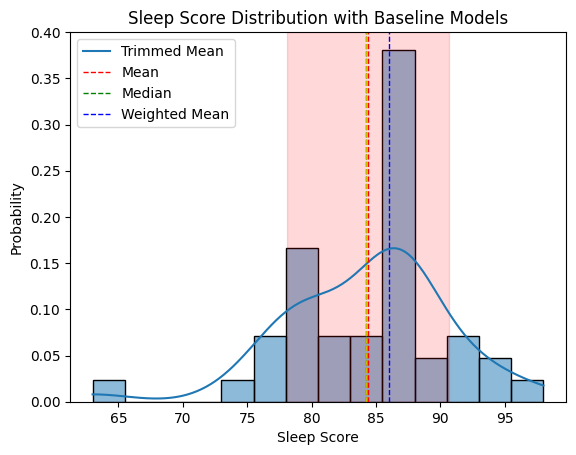

In [152]:
sns.histplot(sleep["Score"], kde=True, stat="probability", binwidth=2.5)
plt.axvline(trim_mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(median, color='b', linestyle='dashed', linewidth=1)
plt.axvline(weighted_mean, color='y', linestyle='dashed', linewidth=1)
plt.axvspan(trim_mean - std_score, trim_mean + std_score, alpha=0.15, color='r')
plt.legend({'Trimmed Mean':trim_mean,'Mean':mean,'Median':median,'Weighted Mean':weighted_mean})
plt.title('Sleep Score Distribution with Baseline Models')
plt.xlabel('Sleep Score')
plt.ylabel('Probability')
plt.show()

In [153]:
def normality_test(data):
    stat, pvalue = stats.shapiro(data)
    if pvalue > 0.05:
        return print(f"The data follows a normal distribution (fail to reject H0) {pvalue:.5f}")
    else:
        return print(f"The data does not follow a normal distribution (reject H0) {pvalue:.5f}")

normality_test(sleep["Score"])

The data does not follow a normal distribution (reject H0) 0.02495


In [154]:
sleep = sleep.rename(columns={"Sleep Score 4 Weeks":"Date"})
sleep.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                42 non-null     datetime64[us]
 1   Score               42 non-null     int64         
 2   Resting Heart Rate  42 non-null     int64         
 3   Body Battery        42 non-null     int64         
 4   Pulse Ox            42 non-null     str           
 5   Respiration         42 non-null     float64       
 6   HRV Status          42 non-null     int64         
 7   Quality             42 non-null     str           
 8   Duration            42 non-null     str           
 9   Sleep Need          42 non-null     str           
 10  Bedtime             42 non-null     object        
 11  Wake Time           42 non-null     object        
dtypes: datetime64[us](1), float64(1), int64(4), object(2), str(4)
memory usage: 4.1+ KB


In [155]:
sleep["HRV Status"].describe()

count    42.000000
mean     46.333333
std       1.300406
min      43.000000
25%      46.000000
50%      46.000000
75%      47.000000
max      48.000000
Name: HRV Status, dtype: float64

In [156]:
mean_hrv = sleep["HRV Status"].mean()
weighted_mean_hrv = np.average(sleep["HRV Status"], weights=sleep["Score"])
trim_mean_hrv = stats.trim_mean(sleep["HRV Status"], proportiontocut=0.1)
median_hrv = sleep["HRV Status"].median()
std_hrv = sleep["HRV Status"].std(ddof=1)

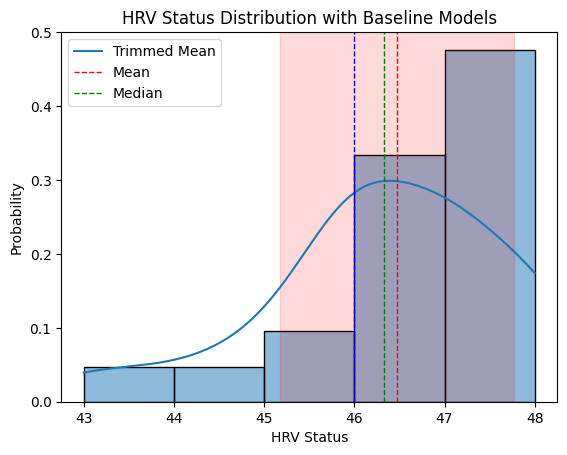

The data does not follow a normal distribution (reject H0) 0.00079


In [157]:
sns.histplot(sleep["HRV Status"], kde=True, stat="probability", binwidth=1)
plt.axvline(trim_mean_hrv, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean_hrv, color='g', linestyle='dashed', linewidth=1)
plt.axvline(median_hrv, color='b', linestyle='dashed', linewidth=1)
plt.axvspan(trim_mean_hrv - std_hrv, trim_mean_hrv + std_hrv, alpha=0.15, color='r')
plt.legend({'Trimmed Mean':trim_mean_hrv,'Mean':mean_hrv,'Median':median_hrv})
plt.title('HRV Status Distribution with Baseline Models')
plt.xlabel('HRV Status')
plt.ylabel('Probability')
plt.show()

normality_test(sleep["HRV Status"])

In [158]:
test = pd.read_csv("/Users/polux9589/Desktop/GYM WORKOUT ANALYSIS PROJECT/processed_data/clean_sleep_data.csv")

In [159]:
test.columns

Index(['Date', 'Main_x', 'Start', 'End', 'InBed hrs', 'Asleep hrs', 'Awake',
       'REM hrs', 'Light hrs', 'Deep hrs', 'Wake Count', 'Efficiency',
       'Fall Asleep', 'Data Source', 'Main_y', 'Start_Nap', 'End_Nap',
       'Asleep_Nap', 'Data Source Nap', 'Overnight HRV', 'Baseline', '7d Avg',
       'Stress', 'RHR'],
      dtype='str')

In [160]:
test.info()

<class 'pandas.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             433 non-null    str    
 1   Main_x           433 non-null    bool   
 2   Start            433 non-null    str    
 3   End              433 non-null    str    
 4   InBed hrs        433 non-null    float64
 5   Asleep hrs       433 non-null    float64
 6   Awake            433 non-null    int64  
 7   REM hrs          331 non-null    float64
 8   Light hrs        333 non-null    float64
 9   Deep hrs         333 non-null    float64
 10  Wake Count       433 non-null    int64  
 11  Efficiency       433 non-null    str    
 12  Fall Asleep      330 non-null    float64
 13  Data Source      433 non-null    str    
 14  Main_y           27 non-null     object 
 15  Start_Nap        27 non-null     str    
 16  End_Nap          27 non-null     str    
 17  Asleep_Nap       27 non-nul

In [161]:
test.describe()

,InBed hrs,Asleep hrs,Awake,REM hrs,Light hrs,Deep hrs,Wake Count,Fall Asleep,Asleep_Nap,Overnight HRV,7d Avg,Stress,RHR
count,433.000000,433.000000,433.000000,331.000000,333.000000,333.000000,433.000000,330.000000,27.000000,43.000000,43.000000,43.000000,43.000000
mean,7.409007,7.093880,18.226328,1.626687,4.176977,1.610911,3.143187,0.318182,36.370370,46.209302,46.348837,25.604651,42.627907
std,1.397680,1.275242,29.766367,0.558589,0.882617,0.383372,4.316506,5.780060,27.244122,3.508888,1.288848,4.525797,1.414605
min,4.450000,2.083333,0.000000,0.116667,2.033333,0.000000,0.000000,0.000000,15.000000,39.000000,43.000000,19.000000,40.000000
25%,6.416667,6.216667,1.000000,1.266667,3.616667,1.383333,1.000000,0.000000,25.500000,43.500000,46.000000,23.000000,42.000000
50%,7.283333,7.016667,9.000000,1.616667,4.100000,1.650000,2.000000,0.000000,30.000000,47.000000,46.000000,24.000000,42.000000
75%,8.100000,7.866667,22.000000,1.933333,4.700000,1.866667,4.000000,0.000000,30.000000,49.000000,47.000000,28.500000,43.000000
max,15.050000,11.766667,265.000000,3.633333,7.016667,2.633333,34.000000,105.000000,158.000000,52.000000,48.000000,38.000000,48.000000


# DAY 3

In [162]:
test.columns

Index(['Date', 'Main_x', 'Start', 'End', 'InBed hrs', 'Asleep hrs', 'Awake',
       'REM hrs', 'Light hrs', 'Deep hrs', 'Wake Count', 'Efficiency',
       'Fall Asleep', 'Data Source', 'Main_y', 'Start_Nap', 'End_Nap',
       'Asleep_Nap', 'Data Source Nap', 'Overnight HRV', 'Baseline', '7d Avg',
       'Stress', 'RHR'],
      dtype='str')

## Asleep hrs Metric

In [170]:
mean_hrv = test["Asleep hrs"].mean()
trim_mean_hrv = stats.trim_mean(test["Asleep hrs"], proportiontocut=0.1)
median_hrv = test["Asleep hrs"].median()
std_hrv = test["Asleep hrs"].std(ddof=1)
variability_hrv = std_hrv / mean_hrv

print(f"Mean: {mean_hrv}, Trimmed Mean: {trim_mean_hrv},\nMedian: {median_hrv}, Std Dev: {std_hrv}, Variability: {variability_hrv}")

Mean: 7.093879907621248, Trimmed Mean: 7.057444764649376,
Median: 7.016666666666667, Std Dev: 1.2752422040381481, Variability: 0.17976653406101545


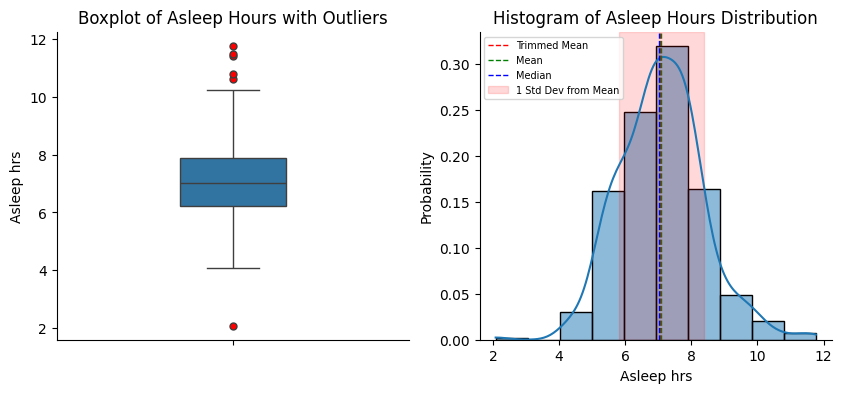

Outliers: 6
Total data points: 433
lower bound: 3.7416666666666676, upper bound: 10.341666666666665


In [164]:
fig, ax = plt.subplots(1,2 , figsize=(10,4))
sns.boxplot(test["Asleep hrs"],
             fliersize=2, flierprops=dict(markerfacecolor='r', marker='o', markersize=5),
            width=0.3, ax=ax[0])
ax[0].set_title('Boxplot of Asleep Hours with Outliers')
sns.despine(ax=ax[0])

sns.histplot(test["Asleep hrs"], kde=True, stat="probability", binwidth=1, fill=True, ax=ax[1])
ax[1].axvline(trim_mean_hrv, color='r', linestyle='dashed', linewidth=1, label='Trimmed Mean')
ax[1].axvline(mean_hrv, color='g', linestyle='dashed', linewidth=1, label='Mean')
ax[1].axvline(median_hrv, color='b', linestyle='dashed', linewidth=1, label='Median')
ax[1].axvspan(mean_hrv - std_hrv, mean_hrv + std_hrv, alpha=0.15, color='r', label='1 Std Dev from Mean')
ax[1].set_title('Histogram of Asleep Hours Distribution')
ax[1].legend(loc="upper left", fontsize=7)
sns.despine(ax=ax[1])
plt.show()

q1 = test["Asleep hrs"].quantile(0.25)
q3 = test["Asleep hrs"].quantile(0.75)
IQR = q3 - q1
outliers = test[(test["Asleep hrs"] < q1 - 1.5 * IQR) | (test["Asleep hrs"] > q3 + 1.5 * IQR)]
print(f"Outliers: {len(outliers)}")
print(f"Total data points: {test["Asleep hrs"].shape[0]}")
print(f"lower bound: {q1 - 1.5 * IQR}, upper bound: {q3 + 1.5 * IQR}")

In [165]:
test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d")

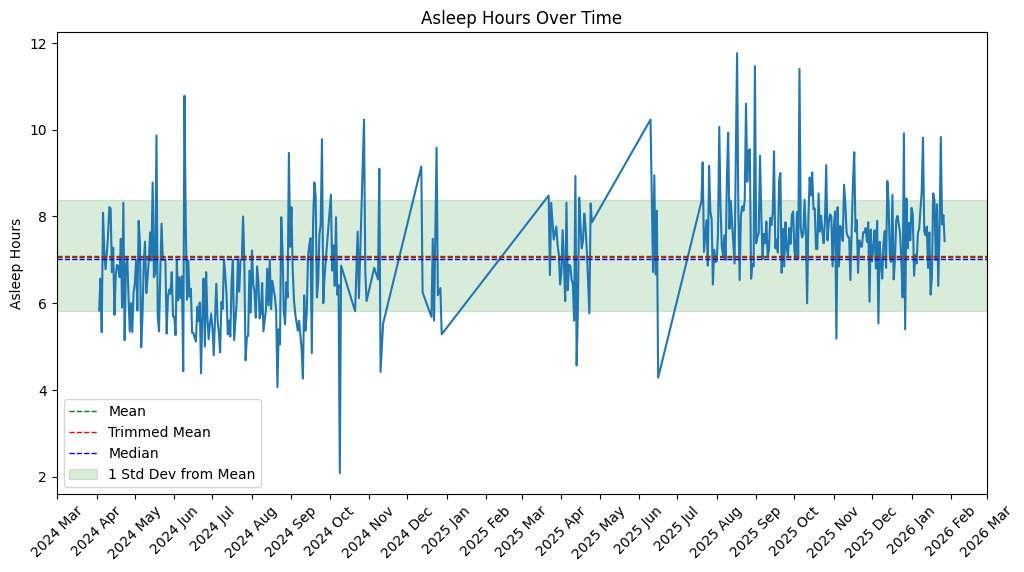

In [166]:
plt.figure(figsize=(12,6))
sns.lineplot(data=test, x="Date", y="Asleep hrs", estimator="mean")
plt.axhline(mean_hrv, color='g', linestyle='dashed', linewidth=1, label='Mean')
plt.axhline(trim_mean_hrv, color='r', linestyle='dashed', linewidth=1, label='Trimmed Mean')
plt.axhline(median_hrv, color='b', linestyle='dashed', linewidth=1, label='Median')
plt.axhspan(mean_hrv-std_hrv, mean_hrv+std_hrv, alpha=0.15, color='g', label='1 Std Dev from Mean')
plt.legend()
plt.title("Asleep Hours Over Time")
plt.xlabel("")
plt.ylabel("Asleep Hours")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
plt.xticks(rotation=45)
plt.show()


## STRESS

In [167]:
mean_stress = test["Stress"].mean()
median_stress = test["Stress"].median()
trim_mean_stress = stats.trim_mean(test["Stress"].dropna(), proportiontocut=0.25)
std_stress = test["Stress"].std(ddof=1)
variablity = std_stress / mean_stress

print(f"Mean: {mean_stress}, Median: {median_stress}, Trimmed Mean: {trim_mean_stress},\nStd Dev: {std_stress}, Variability: {variablity}")


Mean: 25.6046511627907, Median: 24.0, Trimmed Mean: 24.782608695652176,
Std Dev: 4.525796614350108, Variability: 0.1767568160009579


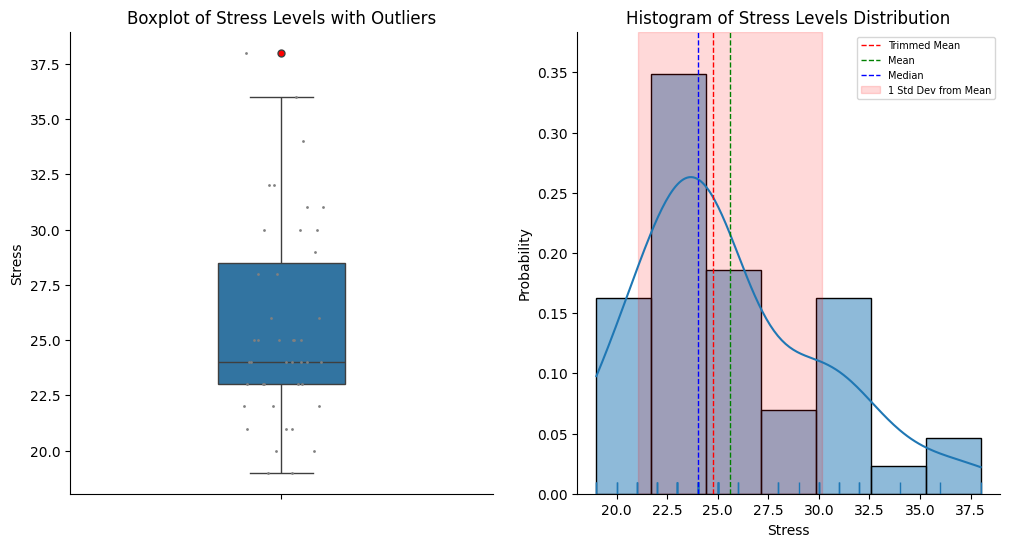

Outliers: 1
Total data points: 433
lower bound: 14.75, upper bound: 36.75


In [168]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(test["Stress"], fliersize=2, flierprops=dict(markerfacecolor="red", marker="o", markersize=5),
             width=0.3, ax=ax[0])
sns.stripplot(test["Stress"], color="grey", size=2, ax=ax[0])
ax[0].set_title('Boxplot of Stress Levels with Outliers')
sns.despine(ax=ax[0])
sns.histplot(test["Stress"], kde=True, stat="probability", fill=True, ax=ax[1])
sns.rugplot(test["Stress"], ax=ax[1])
ax[1].set_title('Histogram of Stress Levels Distribution')
ax[1].axvline(trim_mean_stress, color='r', linestyle='dashed', linewidth=1, label='Trimmed Mean')
ax[1].axvline(mean_stress, color='g', linestyle='dashed', linewidth=1, label='Mean')
ax[1].axvline(median_stress, color='b', linestyle='dashed', linewidth=1, label='Median')
ax[1].axvspan(mean_stress - std_stress, mean_stress + std_stress, alpha=0.15, color='r', label='1 Std Dev from Mean')
ax[1].legend(loc="upper right", fontsize=7)
sns.despine(ax=ax[1])
plt.show()

q1_stress = test["Stress"].quantile(0.25)
q3_stress = test["Stress"].quantile(0.75)
IQR_stress = q3_stress - q1_stress
outliers_stress = test[(test["Stress"] < q1_stress - 1.5 * IQR_stress) | (test["Stress"] > q3_stress + 1.5 * IQR_stress)]
print(f"Outliers: {len(outliers_stress)}")
print(f"Total data points: {test["Stress"].shape[0]}")
print(f"lower bound: {q1_stress - 1.5 * IQR_stress}, upper bound: {q3_stress + 1.5 * IQR_stress}")

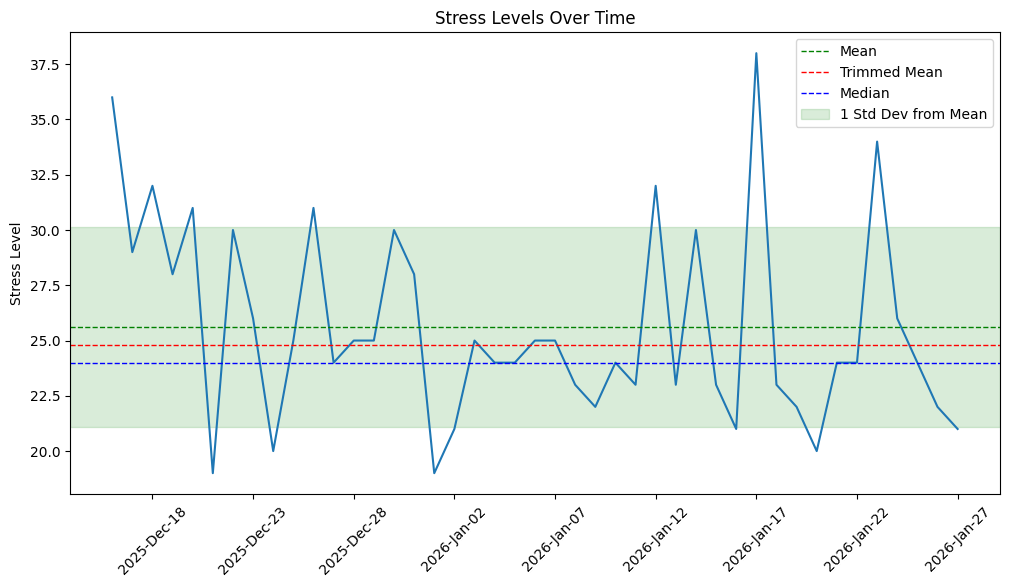

In [169]:
plt.figure(figsize=(12,6))
sns.lineplot(data=test, x="Date", y="Stress", estimator="mean")
plt.title("Stress Levels Over Time")
plt.xlabel("")
plt.ylabel("Stress Level")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.axhline(mean_stress, color='g', linestyle='dashed', linewidth=1, label='Mean')
plt.axhline(trim_mean_stress, color='r', linestyle='dashed', linewidth=1, label='Trimmed Mean')
plt.axhline(median_stress, color='b', linestyle='dashed', linewidth=1, label='Median')
plt.axhspan(mean_stress - std_stress, mean_stress + std_stress, alpha=0.15, color='g', label='1 Std Dev from Mean')
plt.legend()
plt.xticks(rotation=45)
plt.show()